# Imports

In [8]:
import os
import numpy as np
import tensorflow as tf
import keras

from numpy.random import seed
from tensorflow import set_random_seed
from time import strftime
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt

from sklearn import datasets
from keras.datasets import mnist
from matplotlib import pyplot

## Seed for testing
seed(888)
set_random_seed(404)

# Data Collection

In [9]:
# load dataset
(x_train_data, y_train_data), (x_test_data, y_test_data) = mnist.load_data()

# Local Data Paths
LOGGING_PATH = 'tensorboard_mnist_digit_logs/'

# Global parameters
VALIDATION_SIZE = 10000
IM_WIDTH = x_train_data.shape[1]
IM_HEIGHT = x_train_data.shape[2]
IM_CHANNELS = 1
MNIST_INPUT = IM_WIDTH * IM_HEIGHT * IM_CHANNELS
NUM_CLASSES = 10

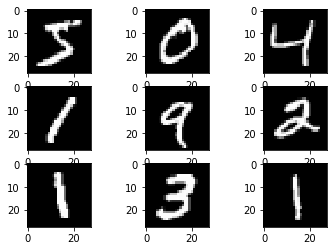

Train: X=(60000, 784), y=(60000,)
Test:  X=(10000, 784), y=(10000,)


In [10]:
# plot first few images
for i in range(9):
    # define subplot
    pyplot.subplot(330 + 1 + i)
    # plot raw pixel data
    pyplot.imshow(x_train_data[i], cmap=pyplot.get_cmap('gray'))

# show the figure
pyplot.show()

# Flatten our input images.
x_train_data = x_train_data.reshape((x_train_data.shape[0], IM_WIDTH * IM_HEIGHT))
x_test_data  = x_test_data.reshape((x_test_data.shape[0], IM_WIDTH * IM_HEIGHT))

# summarize loaded dataset
print('Train: X=%s, y=%s' % (x_train_data.shape, y_train_data.shape))
print('Test:  X=%s, y=%s' % (x_test_data.shape, y_test_data.shape))

# Data Preprocessing

In [11]:
# Normalize our data
x_train_data, x_test_data = x_train_data / 255.0 , x_test_data / 255.0

In [12]:
# expand output shapes into one-hot format for testing and training labels
y_train_data = np.eye(NUM_CLASSES)[y_train_data]
y_test_data  = np.eye(NUM_CLASSES)[y_test_data]

In [13]:
# Generate Validation sets
x_validate = x_train_data[:VALIDATION_SIZE]
y_validate = y_train_data[:VALIDATION_SIZE]

# Update our training sets
x_train_data = x_train_data[VALIDATION_SIZE:]
y_train_data = y_train_data[VALIDATION_SIZE:]

print(x_train_data.shape, x_validate.shape)

(50000, 784) (10000, 784)


# Tensorflow Graph

In [14]:
# Raw inputs of our feature vectors
X = tf.placeholder(tf.float32, shape=[None, MNIST_INPUT], name='X') #MNIST digits are stored in a flattened 28 x 28 x 1 image vector
Y = tf.placeholder(tf.float32, shape=[None, NUM_CLASSES], name='labels') #MNIST digits follow 10 classes, 0 to 9

In [15]:
# Hyperparameters
num_epochs = 50
lr = 0.0001

# Neural Network Architecture
num_hidden1 = 512
num_hidden2 = 64

In [ ]:
def setup_layer(input, weight_dim, bias_dim, name):
    
    with tf.name_scope(name):
        initial_w = tf.truncated_normal(shape=weight_dim, stddev=0.1, seed=42)
        w = tf.Variable(initial_value=initial_w, name='W')

        initial_b = tf.constant(value=0.0, shape=bias_dim)
        b = tf.Variable(initial_value=initial_b, name='B')

        layer_in = tf.matmul(input, w) + b
        
        if name=='out':
            layer_out = tf.nn.softmax(layer_in)
        else:
            layer_out = tf.nn.relu(layer_in)
        
        tf.summary.histogram('weights', w)
        tf.summary.histogram('biases', b)
        
        return layer_out


In [ ]:
layer_1 = setup_layer(X, weight_dim=[MNIST_INPUT, num_hidden1], 
                      bias_dim=[num_hidden1], name='layer_1')

layer_drop = tf.nn.dropout(layer_1, keep_prob=0.8, name='dropout_layer')

layer_2 = setup_layer(layer_drop, weight_dim=[num_hidden1, num_hidden2], 
                      bias_dim=[num_hidden2], name='layer_2')

output = setup_layer(layer_2, weight_dim=[num_hidden2, NUM_CLASSES], 
                      bias_dim=[NUM_CLASSES], name='out')

model_name = f'{num_hidden1}-DO-{num_hidden2} LR{lr} E{num_epochs}'

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Setup Tensorboard

In [ ]:
# Folder for Tensorboard

folder_name = f'{model_name} at {strftime("%H:%M")}'
folder_name = folder_name.replace('.', '')
folder_name = folder_name.replace(':', '')
directory = os.path.join(LOGGING_PATH, folder_name)

try:
    os.makedirs(directory)
except OSError as exception:
    print(exception.strerror)
else:
    print('Successfully created directories!')

Successfully created directories!


# Loss, Optimization and Metrics

In [ ]:
# We are doing batch training, need to aggregate the means
with tf.name_scope('loss_calc'):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y, logits=output))

# Optimization definition
with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(lr)
    train_step = optimizer.minimize(loss)

In [ ]:
# Accuracy Metric
with tf.name_scope('accuracy_calc'):
    correct_pred = tf.equal(tf.argmax(output, axis=1), tf.argmax(Y, axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    
with tf.name_scope('performance'):
    tf.summary.scalar('accuracy', accuracy)
    tf.summary.scalar('cost', loss)

In [ ]:
# Observe the input images in Tensorboard
with tf.name_scope('show_image'):
    x_image = tf.reshape(X, [-1, 28, 28, 1])
    tf.summary.image('image_input', x_image, max_outputs=4)

# Run Model Session

In [ ]:
sess = tf.Session()

In [ ]:
# FileWriter and merge summaries
merged_summary = tf.summary.merge_all()

train_writer = tf.summary.FileWriter(directory + '/train')
train_writer.add_graph(sess.graph)

validation_writer = tf.summary.FileWriter(directory + '/validation')

In [ ]:
# Initialize all the variables
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:
# We are batch training, divide up the training data
size_of_batch = 1000

num_examples = y_train_data.shape[0]
nr_iterations = int(num_examples/size_of_batch)

index_in_epoch = 0

In [ ]:
def next_batch(batch_size, data, labels):
    
    global num_examples
    global index_in_epoch
    
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > num_examples:
        start = 0
        index_in_epoch = batch_size
    
    end = index_in_epoch
    
    return data[start:end], labels[start:end]

In [ ]:
# Training Loop
for epoch in range(num_epochs):
    for i in range(nr_iterations):
        
        batch_x, batch_y = next_batch(batch_size=size_of_batch, data=x_train_data, labels=y_train_data)
        
        feed_dictionary = {X:batch_x, Y:batch_y}
        
        sess.run(train_step, feed_dict=feed_dictionary)
        
    # Aggregate epoch summary and log these changes to the filewriter
    s, batch_accuracy = sess.run(fetches=[merged_summary, accuracy], feed_dict=feed_dictionary)
    
    train_writer.add_summary(s, epoch)
    
    print(f'Epoch {epoch} \t| Training Accuracy = {batch_accuracy}')
    
    # Epoch Validation 
    summary = sess.run(fetches=merged_summary, feed_dict={X:x_validate, Y:y_validate})
    validation_writer.add_summary(summary, epoch)

print('Done training!')

Epoch 0 	| Training Accuracy = 0.6129999756813049
Epoch 1 	| Training Accuracy = 0.7490000128746033
Epoch 2 	| Training Accuracy = 0.8349999785423279
Epoch 3 	| Training Accuracy = 0.8420000076293945
Epoch 4 	| Training Accuracy = 0.8519999980926514
Epoch 5 	| Training Accuracy = 0.8679999709129333
Epoch 6 	| Training Accuracy = 0.8679999709129333
Epoch 7 	| Training Accuracy = 0.8730000257492065
Epoch 8 	| Training Accuracy = 0.871999979019165
Epoch 9 	| Training Accuracy = 0.8709999918937683
Epoch 10 	| Training Accuracy = 0.8759999871253967
Epoch 11 	| Training Accuracy = 0.8790000081062317
Epoch 12 	| Training Accuracy = 0.9300000071525574
Epoch 13 	| Training Accuracy = 0.9490000009536743
Epoch 14 	| Training Accuracy = 0.9610000252723694
Epoch 15 	| Training Accuracy = 0.9629999995231628
Epoch 16 	| Training Accuracy = 0.9589999914169312
Epoch 17 	| Training Accuracy = 0.9620000123977661
Epoch 18 	| Training Accuracy = 0.9639999866485596
Epoch 19 	| Training Accuracy = 0.95999997

In [ ]:
test_accuracy = sess.run(fetches=accuracy, feed_dict={X:x_test_data, Y:y_test_data})
print(f'Accuracy on test set is {test_accuracy:0.2%}')

# Manual Model Interaction

In [ ]:
## Read in an image from all categories

# Find the first MNIST image from each category
digits_found = [True]*10
x_samples = [[]]*10
y_samples = [[]]*10

for i, j in zip(x_test_data, y_test_data):
    mnist_num = np.where(j==1)[0][0]
    if(digits_found[mnist_num]):
        x_samples[mnist_num] = i.reshape(28,28)
        y_samples[mnist_num] = j
        digits_found[mnist_num] = False
    
    # If we have found one of every mnist digit we break
    if(digits_found.count(True) == 0): break

pil_arr   = np.asarray(x_samples)
pil_class = np.asarray(y_samples)

# plot the digits
plt.figure(figsize=[15, 5])
for i, j in zip(pil_arr, pil_class):
    digit = np.where(j == 1)[0][0]
    
    plt.subplot(1, 10, digit+1)
    prediction = sess.run(fetches=tf.argmax(output, axis=1), feed_dict={X:[i.ravel()]})
    
    plt.title(f'Digit: {digit}')
    plt.xlabel(f'Prediction {prediction}')
    plt.xlim(0, i.shape[0])
    plt.ylim(i.shape[1], 0)
    im = Image.fromarray(np.uint8(cm.gist_earth(i)*255))
    plt.imshow(im)

plt.show()


# Rest Model For the Next Run

In [ ]:
train_writer.close()
validation_writer.close()
sess.close()
tf.reset_default_graph()